In [ ]:
# Importing neccessary libraries

In [ ]:
import cv2 as cv
import random
import os
import torch
import timm
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from PIL import Image
from torchinfo import summary
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import notebook 
import optuna
tqdm=notebook.tqdm

In [ ]:
device=torch.device('cuda')

In [2]:
path='D:\Projects\Deep Learning\Rice leaf\Data'
images_paths=[]
labels=[]
subfolders_keys=os.listdir(path)
for lab,subfolder in enumerate(subfolders_keys):
    subfolder_path=os.path.join(path,subfolder)
    list_images=os.listdir(subfolder_path)
    images_paths.extend([os.path.join(subfolder_path,img) for img in list_images])
    labels.extend([lab]*len(list_images))

In [ ]:
random.seed(42)
random_images=random.sample(images_paths,32)
random.seed(42)
random_labels=random.sample(labels,32)

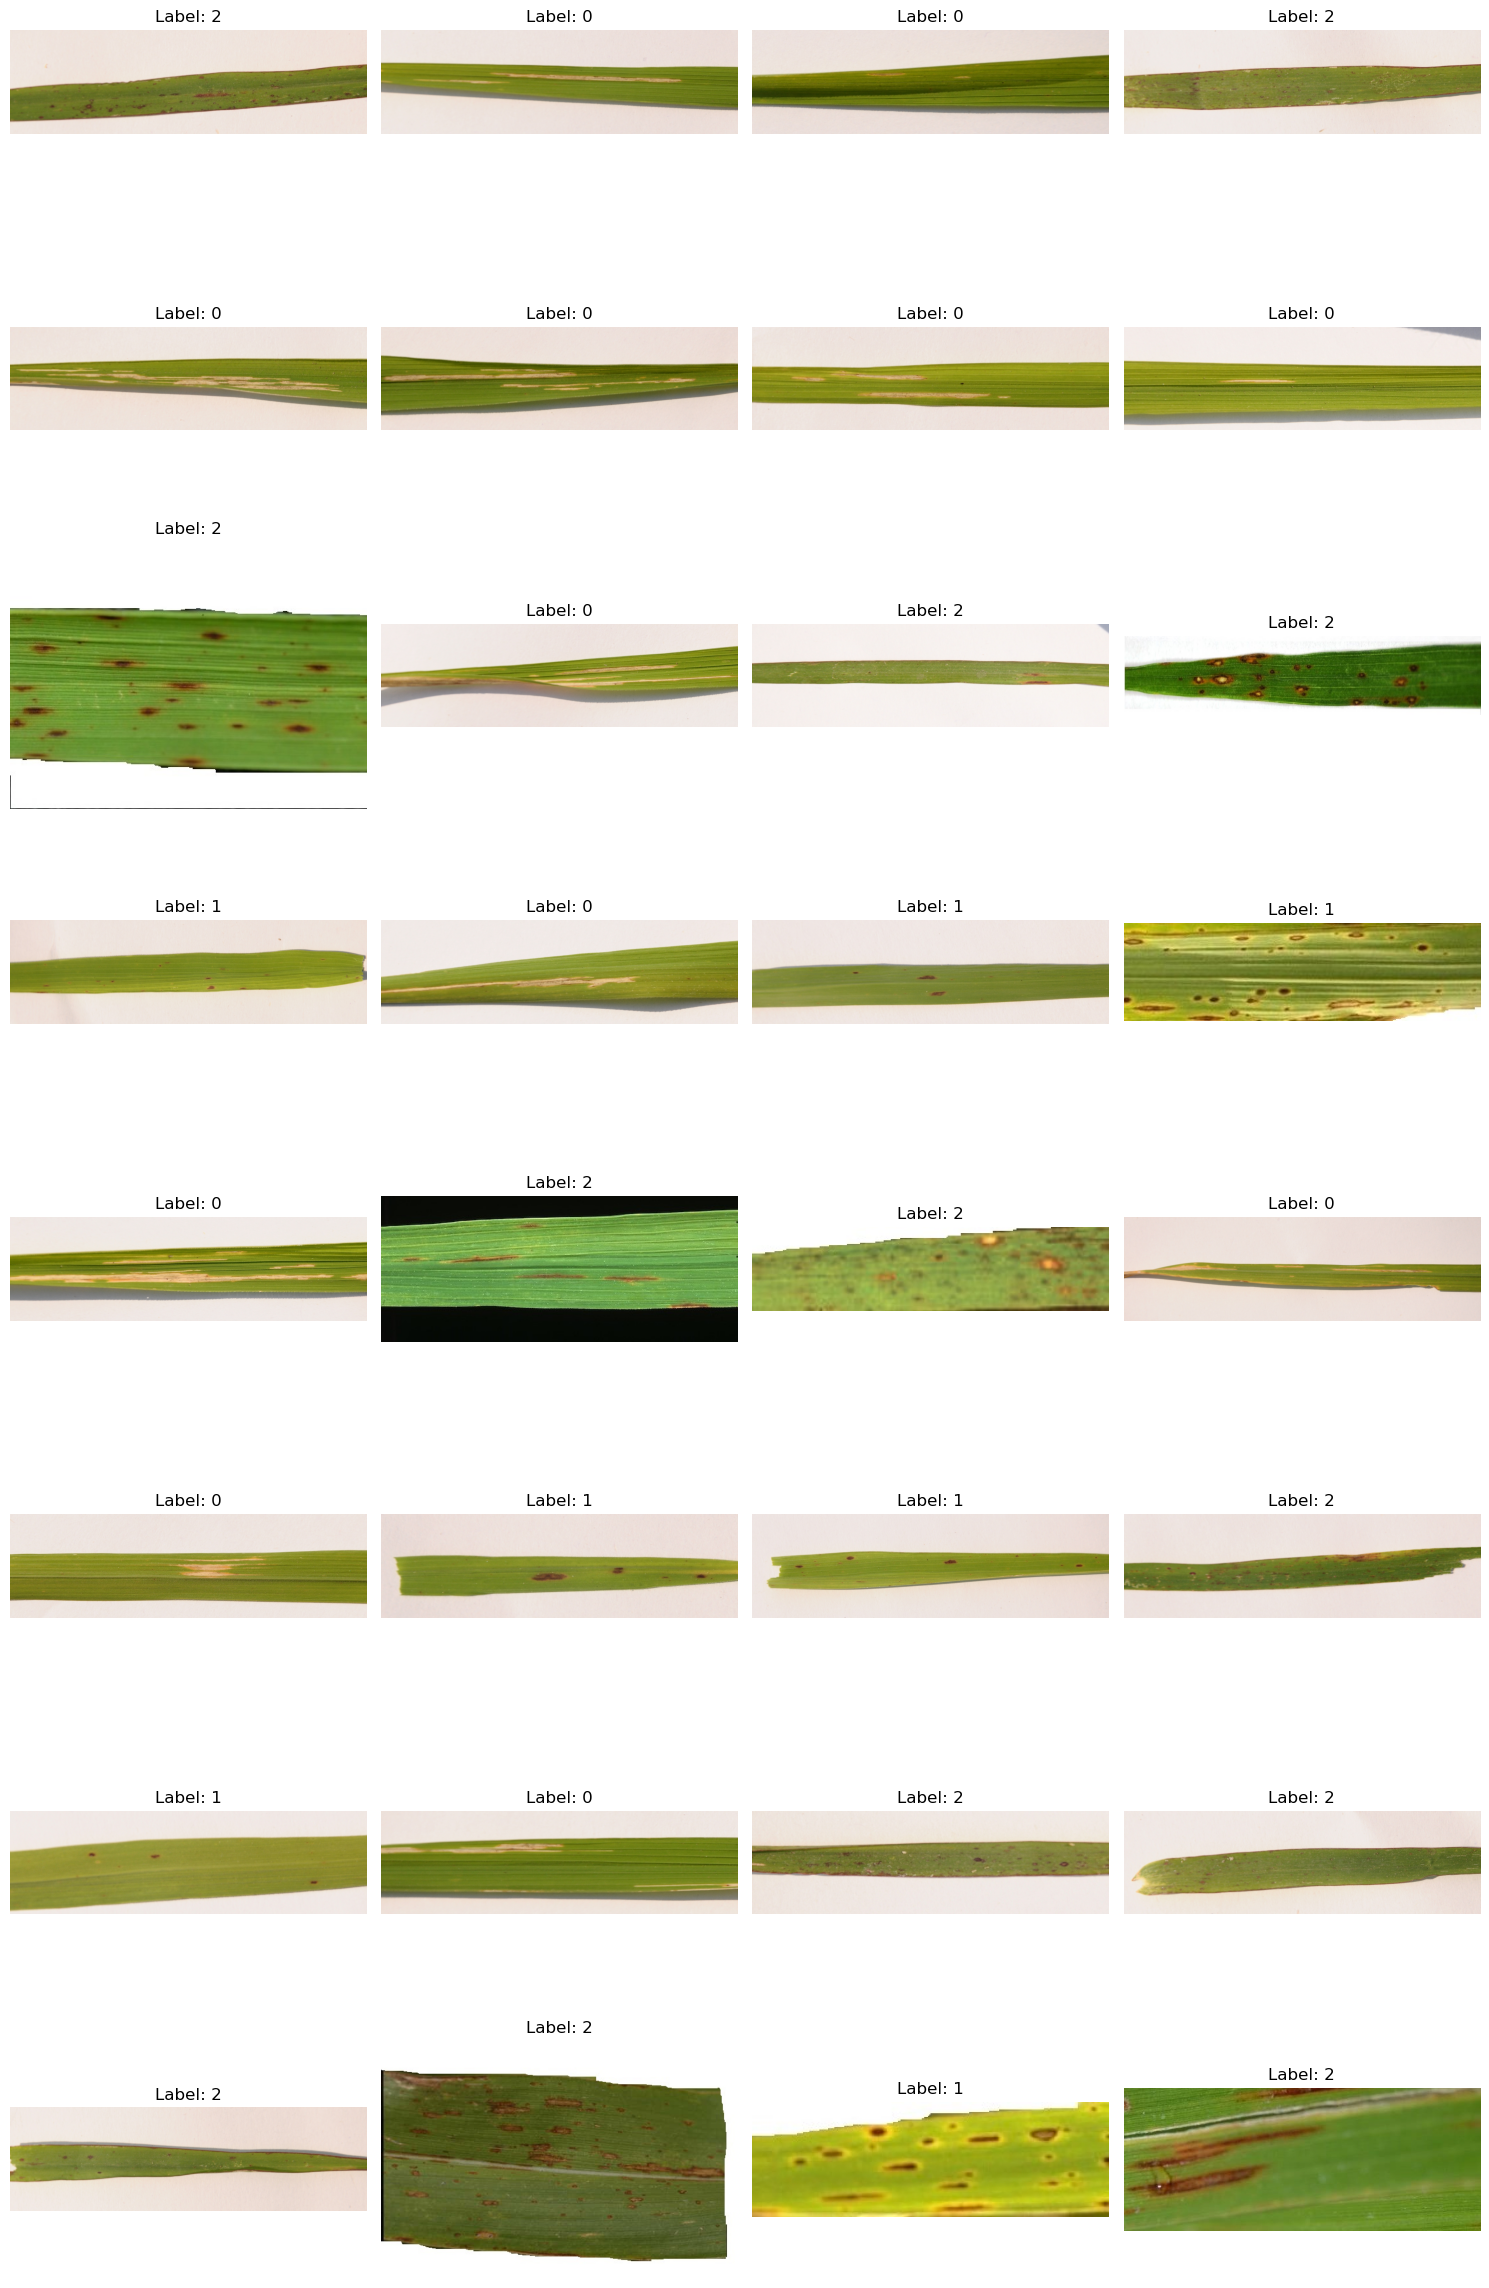

In [76]:
# Define the number of images to display
num_images = len(random_images)
cols = 4  # Number of columns
rows = (num_images // cols) + 1  # Number of rows

plt.figure(figsize=(15, rows * 3))

for i, img_path in enumerate(random_images):
    img = cv.imread(img_path)  # Read image
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)  # Convert BGR to RGB

    plt.subplot(rows, cols, i + 1)
    plt.imshow(img)
    plt.title(f"Label: {random_labels[i]}")
    plt.axis("off")  # Hide axes

plt.tight_layout()
plt.show()

In [ ]:
X_train,X_test,y_train,y_test=train_test_split(images_paths,labels,test_size=0.1)

In [ ]:
class CustomData(Dataset):
    def __init__(self,X,y):
        self.transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomRotation(90),        # Rotate image randomly by ±30 degrees
        transforms.RandomHorizontalFlip(),    # Flip image horizontally
        transforms.RandomVerticalFlip(),      # Flip image vertically
        transforms.RandomPerspective(distortion_scale=0.2, p=0.5),  # Apply perspective transform
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Random translation
        transforms.ToTensor(),
        ])
        self.X=X
        self.y=torch.tensor(y,dtype=torch.long)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, index):
        img=Image.open(self.X[index]).convert('RGB')
        img=self.transform(img)
        return img,self.y[index]


In [41]:
train_data=CustomData(X_train,y_train)
test_data=CustomData(X_test,y_test)
train_loader=DataLoader(train_data,batch_size=10,shuffle=True,pin_memory=True)
test_loader=DataLoader(test_data,batch_size=10,shuffle=False,pin_memory=True)

In [ ]:
class CNN(nn.Module):
    def __init__(self, in_channels, out_channels, num_conv_layers, kernel_size, stride, dropout_rate, fc_layers, use_batchnorm, num_classes=3):
        super(CNN, self).__init__()
        layers = []
        self.conv_layers = nn.Sequential()  # Store conv layers separately

        # Adding convolutional layers
        for i in range(num_conv_layers):
            layers.append(nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding=1))
            if use_batchnorm:
                layers.append(nn.BatchNorm2d(out_channels))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout2d(dropout_rate))
            layers.append(nn.MaxPool2d(2, 2))  # Pooling layer
            in_channels = out_channels
            out_channels *= 2  # Double channels each time

        self.conv_layers = nn.Sequential(*layers)
        self.flatten = nn.Flatten()

        # Determine the FC input size dynamically
        with torch.no_grad():
            sample_input = torch.randn(1, 3, 224, 224)  # A dummy batch of size 1
            conv_output = self.conv_layers(sample_input)
            fc_input_dim = conv_output.view(1, -1).shape[1]  # Compute flattened size dynamically

        fc_layers_list = []
        for i in range(fc_layers):
            fc_layers_list.append(nn.Linear(fc_input_dim, 128))
            if use_batchnorm:
                fc_layers_list.append(nn.BatchNorm1d(128))
            fc_layers_list.append(nn.ReLU())
            fc_layers_list.append(nn.Dropout(dropout_rate))
            fc_input_dim = 128
        
        fc_layers_list.append(nn.Linear(128, num_classes))  # Output layer

        self.fc_layers = nn.Sequential(*fc_layers_list)

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.flatten(x)
        x = self.fc_layers(x)
        return x

In [ ]:
# Define the objective function for Optuna
def objective(trial):

    in_channels = 3

    # Hyperparameters to tune
    out_channels=trial.suggest_int("out_channels",8,64)
    num_conv_layers = trial.suggest_int("num_conv_layers", 2, 5)
    kernel_size = trial.suggest_int("kernel_size", 2,3)
    stride = trial.suggest_int("stride", 1, 2)
    dropout_rate = trial.suggest_float("dropout_rate", 0.2, 0.5)
    fc_layers = trial.suggest_int("fc_layers", 1, 3)
    use_batchnorm = trial.suggest_categorical("use_batchnorm", [True, False])
    epochs=trial.suggest_int("epochs",20,60)

    # Create model
    model = CNN(in_channels,out_channels,num_conv_layers,kernel_size,stride,dropout_rate,fc_layers,use_batchnorm).to(device)

    # Define optimizer and loss function
    lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()

    # Training loop 
    for i in tqdm(range(epochs),desc='Training',leave=True):
        avg_loss = 0
        correct = 0
        total = 0

        # Train
        model.train()
        for bat_feat, bat_lab in train_loader:
            bat_feat, bat_lab = bat_feat.to(device), bat_lab.to(device)

            # Forward pass
            out = model(bat_feat)

            # Loss calculation
            loss = loss_fn(out, bat_lab)

            # Zero gradients
            optimizer.zero_grad()

            # Backward pass
            loss.backward()

            # Update weights
            optimizer.step()

            # Accumulate loss
            avg_loss += loss.item()

            # Accuracy Calculation
            _, predicted = torch.max(out, 1)  # Get predicted class
            correct += (predicted == bat_lab).sum().item()  # Count correct predictions
            total += bat_lab.size(0)  # Total samples

        epoch_loss = avg_loss / len(train_loader)
        train_epoch_acc = 100 * correct / total  # Accuracy percentage


        # prediction
        model.eval()
        net_test_accuracy=0
        test_epoch=30
        with torch.no_grad():
            for j in range(test_epoch):
                test_correct=0
                test_accuracy=0
                test_total=0
                for bat_feat, bat_lab in test_loader:
                    bat_feat, bat_lab = bat_feat.to(device), bat_lab.to(device)
                    # Forward pass
                    out = model(bat_feat)
                    test_correct+=sum(bat_lab==out.argmax(1)).item()
                    test_total+=bat_lab.size(0)
                test_accuracy += (100 * test_correct / test_total ) # Accuracy percentage
                net_test_accuracy+=test_accuracy
        print(f'Epoch : {i+1} | Loss : {epoch_loss:.4f} | Train Accuracy: {train_epoch_acc:.2f}% | Test Accuracy : {net_test_accuracy/test_epoch}')
    return (net_test_accuracy/test_epoch)  # Optuna maximizes accuracy

# Run the optimization
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

# Print best hyperparameters
print("Best hyperparameters:", study.best_params)


# Using Pretrained Model

In [3]:
# Load the Xception model (pretrained on ImageNet)
model = timm.create_model("xception", pretrained=True)


c:\Users\HP\anaconda3\lib\site-packages\timm\models\_factory.py:126: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(


In [4]:
summary(model,input_size=(1,3,224,224))

Layer (type:depth-idx)                   Output Shape              Param #
Xception                                 [1, 1000]                 --
├─Conv2d: 1-1                            [1, 32, 111, 111]         864
├─BatchNorm2d: 1-2                       [1, 32, 111, 111]         64
├─ReLU: 1-3                              [1, 32, 111, 111]         --
├─Conv2d: 1-4                            [1, 64, 109, 109]         18,432
├─BatchNorm2d: 1-5                       [1, 64, 109, 109]         128
├─ReLU: 1-6                              [1, 64, 109, 109]         --
├─Block: 1-7                             [1, 128, 55, 55]          --
│    └─Sequential: 2-1                   [1, 128, 55, 55]          --
│    │    └─SeparableConv2d: 3-1         [1, 128, 109, 109]        8,768
│    │    └─BatchNorm2d: 3-2             [1, 128, 109, 109]        256
│    │    └─ReLU: 3-3                    [1, 128, 109, 109]        --
│    │    └─SeparableConv2d: 3-4         [1, 128, 109, 109]        17,536
│

In [5]:
# Freeze all layers before block 10
cond=False
for name, param in model.named_parameters():
    param.requires_grad = cond
    if "block8" in name:
        cond=True

In [6]:
model.fc=nn.Sequential(
    nn.Linear(2048,128),
    nn.BatchNorm1d(128),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(128,32),
    nn.BatchNorm1d(32),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(32,len(subfolders_keys))
)

In [77]:
# defining Transformer
transformer = transforms.Compose([
        transforms.Resize((299, 299)),  # Xception input size
        transforms.RandomRotation(90),        # Rotate image randomly by ±30 degrees
        transforms.RandomHorizontalFlip(),    # Flip image horizontally
        transforms.RandomVerticalFlip(),      # Flip image vertically
        transforms.RandomPerspective(distortion_scale=0.2, p=0.5),  # Apply perspective transform
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Random translation
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

In [ ]:
class CustomData(Dataset):
    def __init__(self,X,y,transformer):
        self.transform=transformer
        self.X=X
        self.y=torch.tensor(y,dtype=torch.long)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, index):
        img=Image.open(self.X[index]).convert('RGB')
        img=self.transform(img)
        return img,self.y[index]


In [ ]:
train_data=CustomData(X_train,y_train,transformer)
test_data=CustomData(X_test,y_test,transformer)
train_loader=DataLoader(train_data,batch_size=10,shuffle=True,pin_memory=True)
test_loader=DataLoader(test_data,batch_size=10,shuffle=False,pin_memory=True)

In [13]:
model=model.to(device)
optimizer=optim.SGD(model.parameters(),lr=0.01,weight_decay=0.01)
loss_fn=nn.CrossEntropyLoss()

In [14]:
summary(model,input_size=(1,3,229,229))

Layer (type:depth-idx)                   Output Shape              Param #
Xception                                 [1, 3]                    --
├─Conv2d: 1-1                            [1, 32, 114, 114]         (864)
├─BatchNorm2d: 1-2                       [1, 32, 114, 114]         (64)
├─ReLU: 1-3                              [1, 32, 114, 114]         --
├─Conv2d: 1-4                            [1, 64, 112, 112]         (18,432)
├─BatchNorm2d: 1-5                       [1, 64, 112, 112]         (128)
├─ReLU: 1-6                              [1, 64, 112, 112]         --
├─Block: 1-7                             [1, 128, 56, 56]          --
│    └─Sequential: 2-1                   [1, 128, 56, 56]          --
│    │    └─SeparableConv2d: 3-1         [1, 128, 112, 112]        (8,768)
│    │    └─BatchNorm2d: 3-2             [1, 128, 112, 112]        (256)
│    │    └─ReLU: 3-3                    [1, 128, 112, 112]        --
│    │    └─SeparableConv2d: 3-4         [1, 128, 112, 112]    

In [15]:
train_loss=[]
train_accuracy=[]
general_test_accuracy=[]

In [ ]:
for i in tqdm(range(41),desc='Training',leave=True):
    avg_loss = 0
    correct = 0
    total = 0

    # Train
    model.train()
    for bat_feat, bat_lab in train_loader:
        bat_feat, bat_lab = bat_feat.to(device), bat_lab.to(device)

        # Forward pass
        out = model(bat_feat)

        # Loss calculation
        loss = loss_fn(out, bat_lab)

        # Zero gradients
        optimizer.zero_grad()

        # Backward pass
        loss.backward()

        # Update weights
        optimizer.step()

        # Accumulate loss
        avg_loss += loss.item()

        # Accuracy Calculation
        _, predicted = torch.max(out, 1)  # Get predicted class
        correct += (predicted == bat_lab).sum().item()  # Count correct predictions
        total += bat_lab.size(0)  # Total samples

    epoch_loss = avg_loss / len(train_loader)
    train_loss.append(epoch_loss)
    train_epoch_acc = 100 * correct / total  # Accuracy percentage
    train_accuracy.append(train_epoch_acc)


    # prediction
    model.eval()
    net_test_accuracy=0
    test_epoch=30
    with torch.no_grad():
        for j in range(test_epoch):
            test_correct=0
            test_accuracy=0
            test_total=0
            for bat_feat, bat_lab in test_loader:
                bat_feat, bat_lab = bat_feat.to(device), bat_lab.to(device)
                # Forward pass
                out = model(bat_feat)
                test_correct+=sum(bat_lab==out.argmax(1)).item()
                test_total+=bat_lab.size(0)
            test_accuracy += (100 * test_correct / test_total ) # Accuracy percentage
            net_test_accuracy+=test_accuracy
    general_test_accuracy.append(net_test_accuracy/test_epoch)
    print(f'Epoch : {i+1} | Loss : {epoch_loss:.4f} | Train Accuracy: {train_epoch_acc:.2f}% | Test Accuracy : {net_test_accuracy/test_epoch}')


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch : 1 | Loss : 0.9504 | Train Accuracy: 52.34% | Test Accuracy : 53.055555555555564
Epoch : 2 | Loss : 0.7715 | Train Accuracy: 72.90% | Test Accuracy : 75.55555555555556
Epoch : 3 | Loss : 0.6479 | Train Accuracy: 82.24% | Test Accuracy : 79.16666666666666
Epoch : 4 | Loss : 0.6357 | Train Accuracy: 81.31% | Test Accuracy : 80.2777777777778
Epoch : 5 | Loss : 0.5709 | Train Accuracy: 85.98% | Test Accuracy : 83.33333333333333
Epoch : 6 | Loss : 0.5662 | Train Accuracy: 83.18% | Test Accuracy : 81.94444444444443
Epoch : 7 | Loss : 0.4983 | Train Accuracy: 87.85% | Test Accuracy : 83.61111111111111
Epoch : 8 | Loss : 0.5147 | Train Accuracy: 88.79% | Test Accuracy : 82.50000000000001
Epoch : 9 | Loss : 0.4639 | Train Accuracy: 85.98% | Test Accuracy : 83.05555555555557
Epoch : 10 | Loss : 0.4124 | Train Accuracy: 91.59% | Test Accuracy : 88.05555555555556
Epoch : 11 | Loss : 0.3843 | Train Accuracy: 91.59% | Test Accuracy : 87.5
Epoch : 12 | Loss : 0.3381 | Train Accuracy: 93.46% | 

KeyboardInterrupt: 

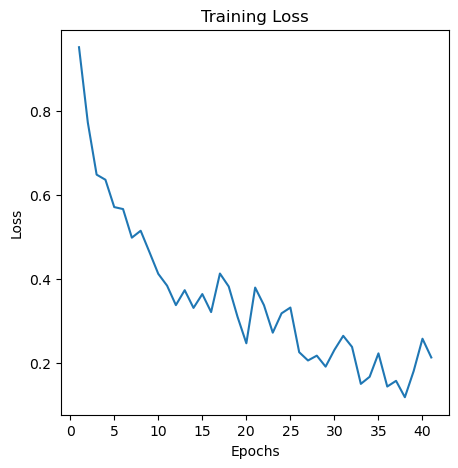

In [38]:
plt.figure(figsize=(5,5))
plt.plot(range(1, 42), train_loss, label="Train Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.show()

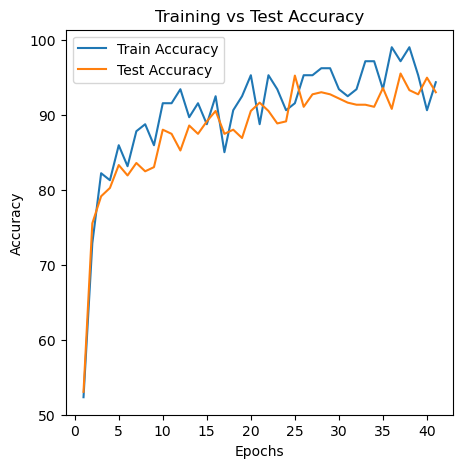

In [34]:
plt.figure(figsize=(5,5))
plt.plot(range(1, 42), train_accuracy, label="Train Accuracy")
plt.plot(range(1, 42), general_test_accuracy, label="Test Accuracy")  # Ensure same x-range
plt.legend()  # No argument needed if labels are set in `plt.plot()`
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs Test Accuracy")
plt.show()

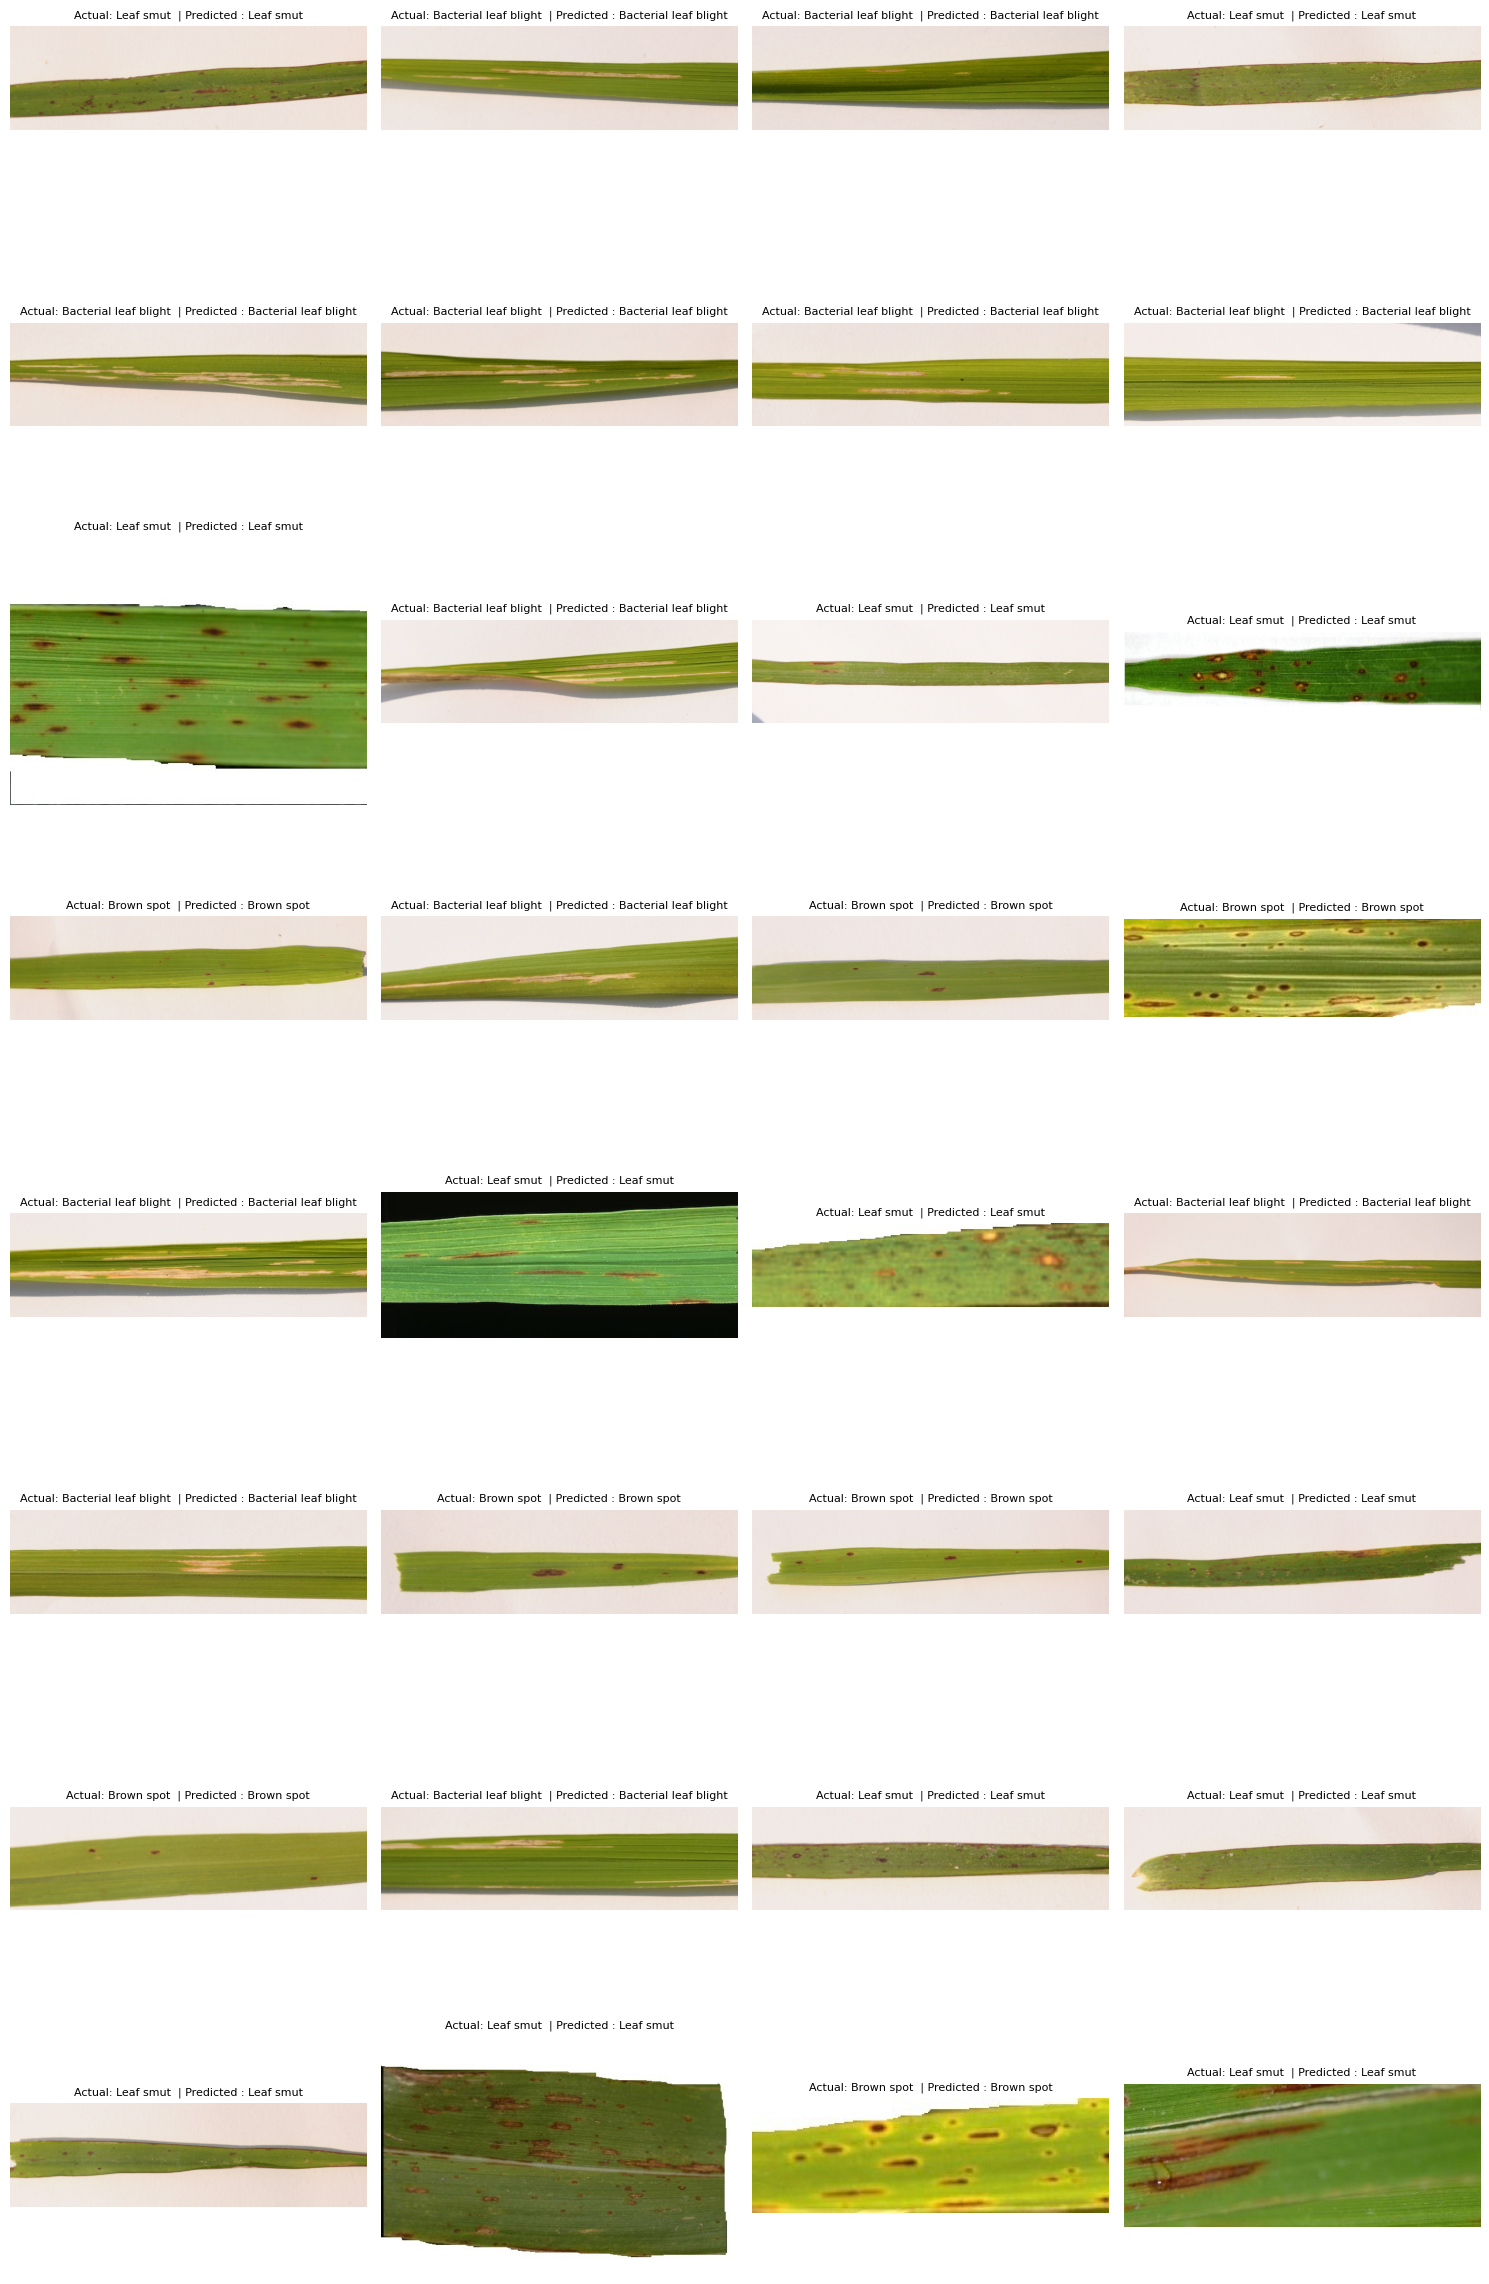

In [97]:
model.eval()
with torch.no_grad():
    # Define the number of images to display
    num_images = len(random_images)
    cols = 4  # Number of columns
    rows = (num_images // cols) + 1  # Number of rows

    plt.figure(figsize=(15, rows * 3))

    for i, img_path in enumerate(random_images):
        # prediction
        img = Image.open(img_path)  # Read image
        # image Prediction
        img_pred=transformer(img).unsqueeze(0).to(device)
        predicted=model(img_pred).argmax(1).item()
        #plotting
        plt.subplot(rows, cols, i + 1)
        plt.imshow(img)
        plt.title(f"Actual: {subfolders_keys[random_labels[i]]}  | Predicted : {subfolders_keys[predicted]}",fontdict={'size':8})
        plt.axis("off")  # Hide axes

    plt.tight_layout()
    plt.show()

In [28]:
torch.save(model.state_dict(), "_rice_leaf_xception_model.pth")

**Summary**

* The project involved building a deep learning model to classify images of rice leaf disease. The
  dataset contained images from 3 type of rice leaf disease namely bacterial bligh, brown spot, and leaf
  smut, The project was divided into several steps, including data exploration, data preprocessing,
  building and training deep learning models, and evaluating model performance.

* During data exploration, I analyzed the dataset and visualized the images to get a better under-
  standing of the data. I observed that the dataset was balanced, with an equal number of images
  for rice leaf diseases. I also noticed that the images were of different sizes and needed to be
  resized to a uniform size before being used for training. I have rescaled them to uniform size of
  224 X 224,

* For data preprocessing, I have normalized the training dataset and also encoded the labels. I 
  used torch transforms class to generate augmented images to increase the size of the dataset
  and reduce overfitting. I  also resized the images and divided them into training, validation, and
  testing sets.

* Overall, the project was successful in building a deep learning model to classify images of rice leaf
  diseases. I  explored the dataset, preprocessed the data, built and trained deep learning models,
  and evaluated their performance. I  also gained insights into how different models behave when
  trained on normal vs. augmented data, what makes a good model in terms of accuracy and loss, and
  how to analyze models with respect to their time taken per epoch. Finally, I  selected Xception
  as the best model and achieved good accuracy on new images.

**Project Challenges**
* Limited amount of data
* Complexity of deep learning models
* Hardware limitations
* Choosing the best model